Linear Regression: 10.576722971499853
Decision Tree: 37.12588334629363
Random Forest: 29.463632345641305
SVM: 27.932471605936882
Bayesian Ridge: 6.565115647791972


<Axes: title={'center': 'Bayesian Ridge'}, xlabel='time'>

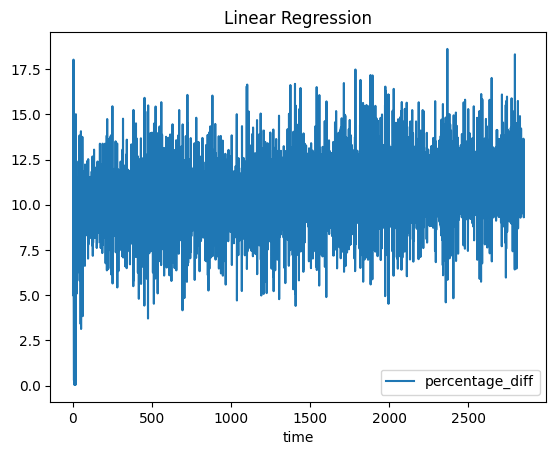

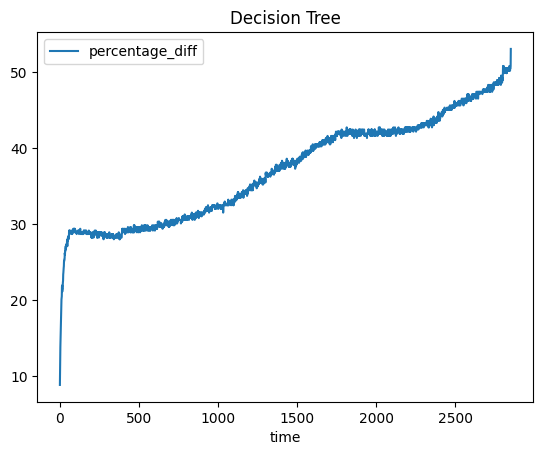

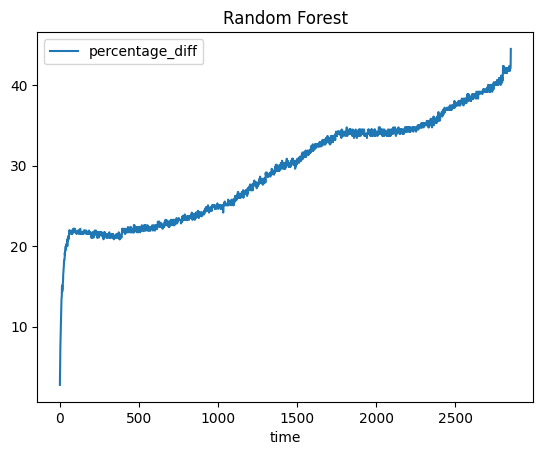

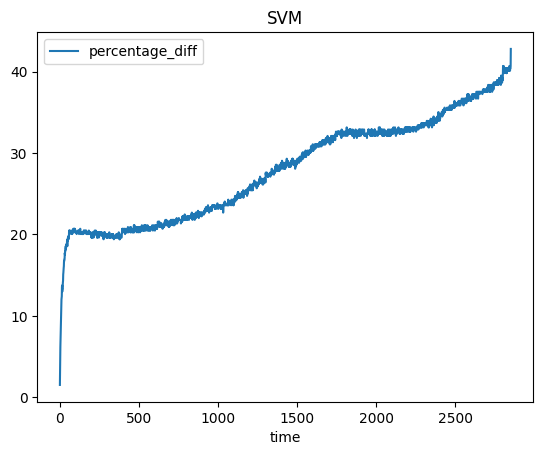

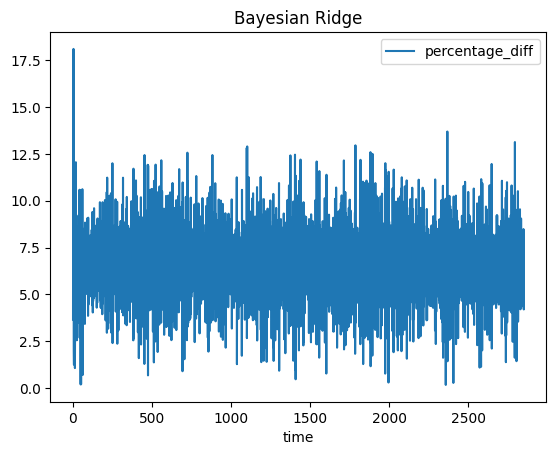

In [15]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge

N = 5  # Number of readings to include in the feature vector
# the feature vector includes only soil moisture for now

# Split data into training and testing by last watering
def split_data(df, test_size=0.2):
    grouped = list(df.groupby('last_watered'))
    random.seed(42) 
    random.shuffle(grouped)
    split_index = int(len(grouped) * (1 - test_size))
    train_groups = grouped[:split_index]
    test_groups = grouped[split_index:]

    train_df = pd.concat([group for _, group in train_groups]).reset_index(drop=True)
    test_df = pd.concat([group for _, group in test_groups]).reset_index(drop=True)
    return train_df, test_df

# Creates time series windows and future soil moisture values to predict
# May be interesting to change this around
def augment_data(train_df):
    augmented_data = []
    grouped = train_df.groupby('last_watered')

    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        timestamps = group['time_stamp'].values
        for _ in range(len(time_series)):  # Augment multiple times per group
            window_end = random.randint(1, len(time_series)-1)
            window_data = time_series[:window_end]
            future_time = random.randint(window_end, len(time_series)-1)
            
            # Pad the window data if it is shorter than N
            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')
            
            augmented_data.append((window_data[:N], future_time, time_series[future_time]))
    return augmented_data

def train_model(augmented_data, model=None):
    if model is None:
        model = LinearRegression()  # Using Linear Regression as a placeholder model

    X_train = []
    y_train = []
    
    for window_data, _, future_moisture in augmented_data:
        X_train.append(window_data)
        y_train.append(future_moisture)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    model.fit(X_train, y_train)
    return model

# evaluate by percentage difference
def evaluate_model(model, test_df):
    total_percentage_diff = 0
    grouped = test_df.groupby('last_watered')

    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        for i in range(1, len(time_series)):
            window_data = time_series[max(0, i-N):i]
            
            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')

            actual_soil_moisture = time_series[i]
            X_test = np.array(window_data).reshape(1, -1)
            predicted_soil_moisture = model.predict(X_test)[0]
            percentage_diff = abs(actual_soil_moisture - predicted_soil_moisture) / actual_soil_moisture * 100
            total_percentage_diff += percentage_diff

    average_percentage_diff = total_percentage_diff / len(test_df)
    return average_percentage_diff

# evalute all points, returns the accuracy of different amounts of time into the future, as a df
def evaluate_model_over_time(model, test_df):
    total_percentage_diff = 0
    grouped = test_df.groupby('last_watered')
    results = []
    for _, group in grouped:
        time_series = group['soil_moisture_1'].values
        for i in range(1, len(time_series)):
            window_data = time_series[max(0, i-N):i]
            
            if len(window_data) < N:
                window_data = np.pad(window_data, (N - len(window_data), 0), mode='edge')

            actual_soil_moisture = time_series[i]
            X_test = np.array(window_data).reshape(1, -1)
            predicted_soil_moisture = model.predict(X_test)[0]
            percentage_diff = abs(actual_soil_moisture - predicted_soil_moisture) / actual_soil_moisture * 100
            results.append([i, percentage_diff])
    return pd.DataFrame(results, columns=['time', 'percentage_diff'])

        
# Example usage with a sample dataframe
df = pd.read_csv("palm_features.csv")
# Split the data into training and testing sets
train_df, test_df = split_data(df)
# Augment the training data
augmented_data = augment_data(train_df)
# Train models
model_lin = train_model(augmented_data, model=LinearRegression())
model_tree = train_model(augmented_data, model=DecisionTreeRegressor())
model_forest = train_model(augmented_data, model=RandomForestRegressor())
model_svm = train_model(augmented_data, model=SVR())
model_bayes = train_model(augmented_data, model=BayesianRidge())

# Evaluate the models
print(f"Linear Regression: {evaluate_model(model_lin, test_df)}")
print(f"Decision Tree: {evaluate_model(model_tree, test_df)}")
print(f"Random Forest: {evaluate_model(model_forest, test_df)}")
print(f"SVM: {evaluate_model(model_svm, test_df)}")
print(f"Bayesian Ridge: {evaluate_model(model_bayes, test_df)}")

#evalute into the future and plot
results_lin = evaluate_model_over_time(model_lin, test_df)
results_tree = evaluate_model_over_time(model_tree, test_df)
results_forest = evaluate_model_over_time(model_forest, test_df)
results_svm = evaluate_model_over_time(model_svm, test_df)
results_bayes = evaluate_model_over_time(model_bayes, test_df)

results_lin.plot(x='time', y='percentage_diff', title='Linear Regression')
results_tree.plot(x='time', y='percentage_diff', title='Decision Tree')
results_forest.plot(x='time', y='percentage_diff', title='Random Forest')
results_svm.plot(x='time', y='percentage_diff', title='SVM')
results_bayes.plot(x='time', y='percentage_diff', title='Bayesian Ridge')


In [13]:
augment_data(train_df)
# data shape is:
# (window_data, future_time, future_moisture)

[(array([83. , 76.1, 75.1, 74.3, 73.8]), 1918, np.float64(60.4)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 991, np.float64(65.2)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3330, np.float64(57.3)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 2775, np.float64(59.4)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 1794, np.float64(60.8)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 506, np.float64(66.0)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 1848, np.float64(60.8)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3302, np.float64(57.4)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 2407, np.float64(60.0)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3047, np.float64(58.6)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 2170, np.float64(60.2)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3046, np.float64(58.5)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 1166, np.float64(64.6)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3190, np.float64(57.8)),
 (array([83. , 76.1, 75.1, 74.3, 73.8]), 3076, np.float64(58.5)),
 (array([83.